<a href="https://colab.research.google.com/github/AregSP/20newsgroups_spx/blob/main/20newsgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lang, Ken. "Newsweeder: Learning to filter netnews." Machine Learning Proceedings 1995. Morgan Kaufmann, 1995. 331-339.

# Fetch the 20 newsgroups dataset using scikit learn

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()

print(newsgroups.target_names) # 20 classes

text = pd.Series(newsgroups.data, name='text')

text

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...
...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311,From: westes@netcom.com (Will Estes)\nSubject:...
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...


# Convert the data to high dimensional numerical format using vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english') # initialize the transformer instance that will skip on common words (e.g. 'and')

vectors = vectorizer.fit_transform(text)

vectors # now the dataset is a very sparse matrix with thousands of features. each feature represents a symbol in the vocabulary and its value represents the weight (importance) of the symbol in the given instance. this is what TF-IDF technique does. other preprocessing steps like lowercasing, tokenization and converting words to their roots are also handled under the hood.

<11314x129796 sparse matrix of type '<class 'numpy.float64'>'
	with 1300729 stored elements in Compressed Sparse Row format>

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectors, newsgroups.target, test_size=0.2, random_state=42)

Visualize class distribution (mostly balanced, we can go straight to model picking)

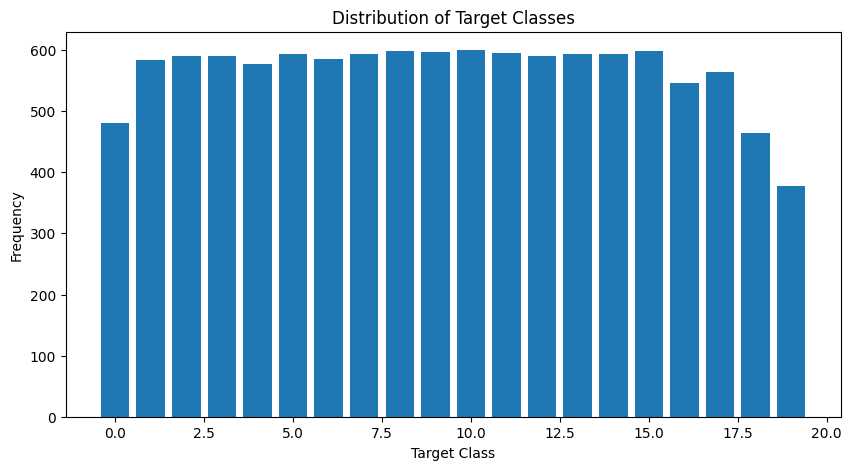

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Visualize target distribution
target_counts = Counter(newsgroups.target)
plt.figure(figsize=(10, 5))
plt.bar(target_counts.keys(), target_counts.values())
plt.xlabel('Target Class')
plt.ylabel('Frequency')
plt.title('Distribution of Target Classes')
plt.show()

# Algorithm evaluation (Naive Bayes, Logistic Regression, SVM)

In [ ]:
from spxr.ml import compare_classifiers # custom function that makes out-of-sample predictions under the hood and outputs the specified metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

eval = False
if eval:
  # comparing lightweight models suitable for text classification (can handle high numbers of features efficiently)
  compare_classifiers(X_train, y_train, models=[MultinomialNB(), LogisticRegression(), LinearSVC(), SGDClassifier()], average='macro', metrics=['f1']) # Linear SVM performs the best initially

# Hyperparameter tuning

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grids for MultinomialNB and SGDClassifier
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 10, 0.01, 0.05, 0.001]}
param_grid_svm = {'loss': ['hinge'], 'penalty': ['l2'], 'alpha': [0.0001, 0.001, 0.01]}
param_grid_log = {'loss': ['log_loss'], 'penalty': ['l2'], 'alpha': [0.0001, 0.00001, 0.00005]}

# logistic regression and linearsvm will be trained with Stochastic Gradient Descent, as it provides the same results with more speed

# Create models
model_nb = MultinomialNB()
sgd = SGDClassifier(random_state=42)

search = False
if search:

  # Perform grid search for MultinomialNB
  grid_search_nb = GridSearchCV(estimator=model_nb, param_grid=param_grid_nb, cv=5, scoring='f1_macro')
  grid_search_nb.fit(X_train, y_train)

  print("MultinomialNB Best parameters: ", grid_search_nb.best_params_)
  print("MultinomialNB Best score: ", grid_search_nb.best_score_)
  best_model_nb = grid_search_nb.best_estimator_


  # Perform grid search for SGDClassifier
  grid_search_svm = GridSearchCV(estimator=sgd, param_grid=param_grid_svm, cv=5, scoring='f1_macro')
  grid_search_svm.fit(X_train, y_train)

  grid_search_log = GridSearchCV(sgd, param_grid=param_grid_log, cv=5, scoring='f1_macro')
  grid_search_log.fit(X_train, y_train)

  print("SVM Best parameters: ", grid_search_svm.best_params_)
  print("SVM Best score: ", grid_search_svm.best_score_)
  best_model_svm = grid_search_svm.best_estimator_

  print("Log Best parameters: ", grid_search_log.best_params_)
  print("Log Best score: ", grid_search_log.best_score_)
  best_model_log = grid_search_log.best_estimator_

  compare_classifiers(X_train, y_train, models=[best_model_nb, best_model_svm, best_model_log], average='macro', metrics=['f1'])

# best hyperparameters and the f1 scores:
# nb - alpha 0.01 (0.89)
# log reg - alpha 0.00005 penalty l2 (0.903)
# svm - alpha 0.0001 penalty l2 (0.908)

# Building an ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

svm = CalibratedClassifierCV(SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')) # enable probabilities for sgd-svm
log = SGDClassifier(alpha=0.00005, loss='log_loss', penalty='l2')
nb = MultinomialNB(alpha=0.01)

estimators = [('nb', nb), ('log', log), ('svm', svm)]

voters = VotingClassifier(estimators=estimators, voting='soft')

voters.fit(X_train, y_train)

run = False
if run:
  compare_classifiers(X_train, y_train, models=[voters], average='macro', metrics=['f1']) # additional 0.3% of performance (0.911)

# Evaluate on test set

In [ ]:
from sklearn.metrics import classification_report

X_test_pred = voters.predict(X_test)

print(classification_report(y_test, X_test_pred)) # solid performance (0.92 f1 macro score). classification report reveals that the model performs slightly worse for some classes (computer graphics, pc hardware, religion) and performs almost flawless on space documents

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        97
           1       0.79      0.85      0.81       104
           2       0.91      0.84      0.87       115
           3       0.76      0.80      0.78       123
           4       0.96      0.90      0.93       126
           5       0.89      0.93      0.91       106
           6       0.84      0.90      0.87       109
           7       0.96      0.94      0.95       139
           8       0.96      0.97      0.96       122
           9       0.98      0.97      0.98       102
          10       0.98      0.97      0.98       108
          11       0.99      0.97      0.98       125
          12       0.90      0.88      0.89       114
          13       0.98      0.97      0.98       119
          14       0.99      0.99      0.99       127
          15       0.92      0.94      0.93       122
          16       0.96      0.97      0.96       121
          17       0.96    